In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/pins-face-recognition/105_classes_pins_dataset/pins_Alex Lawther/Alex Lawther233_93.jpg
/kaggle/input/pins-face-recognition/105_classes_pins_dataset/pins_Alex Lawther/Alex Lawther37_110.jpg
/kaggle/input/pins-face-recognition/105_classes_pins_dataset/pins_Alex Lawther/Alex Lawther228_91.jpg
/kaggle/input/pins-face-recognition/105_classes_pins_dataset/pins_Alex Lawther/Alex Lawther92_145.jpg
/kaggle/input/pins-face-recognition/105_classes_pins_dataset/pins_Alex Lawther/Alex Lawther40_113.jpg
/kaggle/input/pins-face-recognition/105_classes_pins_dataset/pins_Alex Lawther/Alex Lawther196_69.jpg
/kaggle/input/pins-face-recognition/105_classes_pins_dataset/pins_Alex Lawther/Alex Lawther159_45.jpg
/kaggle/input/pins-face-recognition/105_classes_pins_dataset/pins_Alex Lawther/Alex Lawther129_24.jpg
/kaggle/input/pins-face-recognition/105_classes_pins_dataset/pins_Alex Lawther/Alex Lawther182_63.jpg
/kaggle/input/pins-face-recognition/105_classes_pins_dataset/pins_Alex Lawther/Ale

In [2]:
import os
import numpy as np
import PIL.Image as Image

def read_images(path, sz=None):
    c = 0
    X,y = [], []
    print("OK")
    for dirname, dirnames, filenames in os.walk(path):
        for subdirname in dirnames:
#             print(subdirname)
            subject_path = os.path.join(dirname, subdirname)
            x=0
            for filename in os.listdir(subject_path):
                try:
                    im = Image.open(os.path.join(subject_path, filename))
                    im = im.convert("L")
                    # resize to given size (if given)
                    if (sz is not None):
                        im = im.resize(sz, Image.ANTIALIAS)
                    X.append(np.asarray(im, dtype=np.uint8))
                    y.append(c)
                    x=x+1
                except IOError:
                    print("I/O error({0}): {1}".format(errno, strerror))
                except:
                    print("Unexpected error:", sys.exc_info()[0])
                    raise
                if x>50:
                    break
            c=c+1
            if c>70:
                break
              
    return [X,y]


[X, y] = read_images('../input/pins-face-recognition/105_classes_pins_dataset', (64, 64))

OK


In [3]:
print(X[0])

[[231 252 228 ... 106 111 111]
 [235 253 221 ... 111 118 120]
 [239 254 209 ... 116 121 122]
 ...
 [249 249 249 ...  97  76 133]
 [249 249 249 ... 105  92 131]
 [249 249 249 ... 110  93 129]]


In [4]:
def generate_train_image_pairs(images_dataset, labels_dataset):
    unique_labels = np.unique(labels_dataset)
    label_wise_indices = dict()
    for label in unique_labels:
        label_wise_indices.setdefault(label,
                                      [index for index, curr_label in enumerate(labels_dataset) if
                                       label == curr_label])
    
    pair_images = []
    pair_labels = []
    for index, image in enumerate(images_dataset):
        pos_indices = label_wise_indices.get(labels_dataset[index])
        pos_image = images_dataset[np.random.choice(pos_indices)]
        pair_images.append((image, pos_image))
        pair_labels.append(1)

        neg_indices = np.where(labels_dataset != labels_dataset[index])
        neg_image = images_dataset[np.random.choice(neg_indices[0])]
        pair_images.append((image, neg_image))
        pair_labels.append(0)
    return np.array(pair_images), np.array(pair_labels)
train_X, train_Y=generate_train_image_pairs(X, y)

In [5]:
print(train_X.shape, train_Y.shape)

(7242, 2, 64, 64) (7242,)


In [6]:
import tensorflow as tf
def create_model():
    inputs = tf.keras.Input((64, 64, 1))
    x = tf.keras.layers.Conv2D(96, (11, 11), padding="same", activation="relu")(inputs)
    x = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(x)
    x = tf.keras.layers.Dropout(0.3)(x)

    x = tf.keras.layers.Conv2D(256, (5, 5), padding="same", activation="relu")(x)
    x = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(x)
    x = tf.keras.layers.Dropout(0.3)(x)

    x = tf.keras.layers.Conv2D(384, (3, 3), padding="same", activation="relu")(x)
    x = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(x)
    x = tf.keras.layers.Dropout(0.3)(x)

    pooledOutput = tf.keras.layers.GlobalAveragePooling2D()(x)
    pooledOutput = tf.keras.layers.Dense(1024)(pooledOutput)
    outputs = tf.keras.layers.Dense(128)(pooledOutput)

    model = tf.keras.Model(inputs, outputs)
    return model

In [7]:
from keras import backend as k

feature_extractor = create_model()
imgA = tf.keras.Input(shape=(64, 64, 1))
imgB = tf.keras.Input(shape=(64, 64, 1))
featA = feature_extractor(imgA)
featB = feature_extractor(imgB)

def euclidean_distance(vectors):
    (featA, featB) = vectors
    sum_squared = k.sum(k.square(featA - featB), axis=1, keepdims=True)
    return k.sqrt(k.maximum(sum_squared, k.epsilon()))

distance = tf.keras.layers.Lambda(euclidean_distance)([featA, featB])
outputs = tf.keras.layers.Dense(1, activation="sigmoid")(distance)
model = tf.keras.Model(inputs=[imgA, imgB], outputs=outputs)
model.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])

history = model.fit([train_X[:2500, 0], train_X[:2500, 1]], train_Y[:2500],validation_split=0.2,batch_size=64,epochs=40)

2022-04-17 20:41:11.176583: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-04-17 20:41:11.282139: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-04-17 20:41:11.283129: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-04-17 20:41:11.284435: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

Epoch 1/40


2022-04-17 20:41:15.208678: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


32/32 [==============================] - 11s 94ms/step - loss: 1.6550 - accuracy: 0.4945 - val_loss: 0.6854 - val_accuracy: 0.4960
Epoch 2/40
32/32 [==============================] - 2s 56ms/step - loss: 0.6882 - accuracy: 0.5900 - val_loss: 0.6900 - val_accuracy: 0.5860
Epoch 3/40
32/32 [==============================] - 2s 56ms/step - loss: 0.6848 - accuracy: 0.6175 - val_loss: 0.6836 - val_accuracy: 0.6180
Epoch 4/40
32/32 [==============================] - 2s 56ms/step - loss: 0.6852 - accuracy: 0.5895 - val_loss: 0.6873 - val_accuracy: 0.5720
Epoch 5/40
32/32 [==============================] - 2s 56ms/step - loss: 0.6851 - accuracy: 0.6065 - val_loss: 0.6847 - val_accuracy: 0.5920
Epoch 6/40
32/32 [==============================] - 2s 57ms/step - loss: 0.6821 - accuracy: 0.6120 - val_loss: 0.6853 - val_accuracy: 0.5700
Epoch 7/40
32/32 [==============================] - 2s 56ms/step - loss: 0.6827 - accuracy: 0.6025 - val_loss: 0.6851 - val_accuracy: 0.5840
Epoch 8/40
32/32 [=====

In [8]:
model.save("model.h5")

In [9]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
def print_image(img):
    imgplot = plt.imshow(img)
    plt.show()

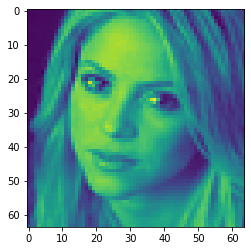

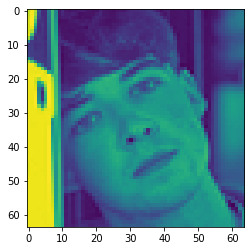

Matched


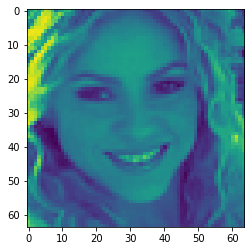

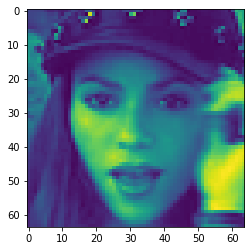

Matched


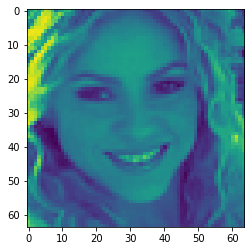

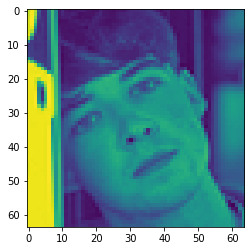

Not Matched


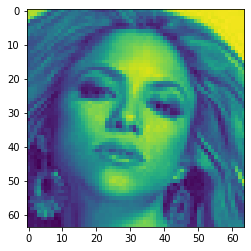

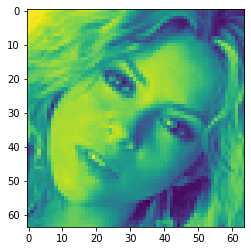

Matched


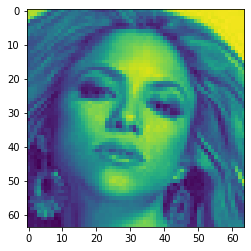

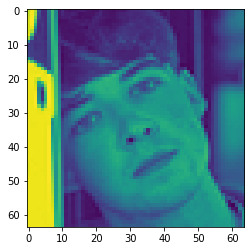

Matched


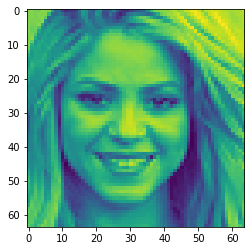

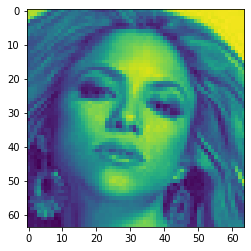

Matched


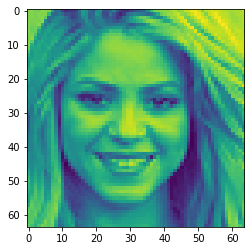

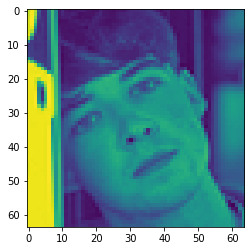

Not Matched


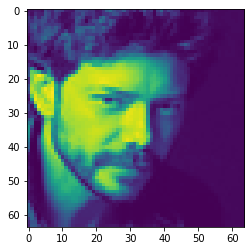

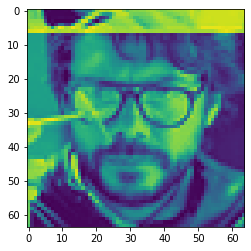

Matched


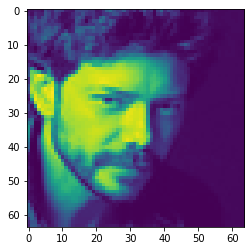

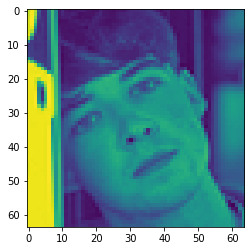

Matched
Accuracy  59.050000000000004 %


In [10]:
one=0
zero=1
total=0
count=0
for i in range(3000, 5000):
    pair_image1 = np.expand_dims(train_X[i][0], axis=-1)
    pair_image1 = np.expand_dims(pair_image1, axis=0)
    pair_image2 = np.expand_dims(train_X[i][1], axis=-1)
    pair_image2 = np.expand_dims(pair_image2, axis=0)
    prediction = model.predict([pair_image1, pair_image2])[0][0]
    if i>4990:
        print_image(train_X[i][0])
        print_image(train_X[i][1])
        if prediction>0.4:
            print("Matched")
        else:
            print("Not Matched")
    if (prediction>0.4) == train_Y[i]:
        count+=1
    total+=1
print("Accuracy ",count/total*100,"%")
#     print(train_Y[i], prediction)

In [11]:
print(one, zero)

0 1


In [12]:
temp=train_X[1:2]
print(temp.shape)
print(train_X.shape)

(1, 2, 64, 64)
(7242, 2, 64, 64)


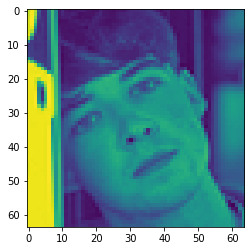

In [13]:
import matplotlib.pyplot as plt
plt.imshow(train_X[0][0])


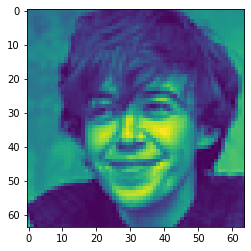

In [14]:
plt.imshow(train_X[0][1])

In [15]:
threshold=0.5
total=0
count=0
for index, image in enumerate(X_test):
    test_image_pairs, test_label_pairs = generate_test_image_pairs(Database_images, Database_labels, image)
#     print(test_image_pairs.shape)
#     print(test_label_pairs.shape)
    
    # for each pair in the test image pair, predict the similarity between the images
    pred=0
    label=-1
    for index, pair in enumerate(test_image_pairs):
        pair_image1 = np.expand_dims(pair[0], axis=-1)
        pair_image1 = np.expand_dims(pair_image1, axis=0)
        pair_image2 = np.expand_dims(pair[1], axis=-1)
        pair_image2 = np.expand_dims(pair_image2, axis=0)
        prediction = model.predict([pair_image1, pair_image2])[0][0]
        if prediction>pred:
            pred=prediction
            label=Database_dict[str(pair[1])]
    if pred>threshold:
#         print(pred)
        if label==y_test[index]:
            count+=1
    else:
        pass
    total+=1
print("Accuracy= ",count/total*100,"%")

NameError: name 'X_test' is not defined